In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import math
import matplotlib.pyplot as plt
from io import BytesIO, StringIO
import boto3

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [31]:
fn = xr.open_dataset('/Users/victoriaford/Desktop/Train_Files/VCAPCD_OJ.nc')
df = fn.to_dataframe()
# df

In [39]:
def create_bins(data, bin_size=0.25):
    '''Create bins from data covering entire data range'''

    # set up bins
    b_min = np.floor(np.nanmin(data))
    b_max = np.ceil(np.nanmax(data))
    bins = np.arange(b_min, b_max, bin_size)
    print(b_min, b_max)

    return bins


def synergistic_flag(df, num_temp_vars):  
    '''
    In frequent values, if air temp is flagged, dew point is also flagged, and vice versa.
    Applies appropriate flag in corresponding vars
    '''

    # need to identify which flag is placed
    # 23 for all obs/years check
    # 24 for all seasons/years check
    flags_to_set = [23, 24]
    
    for flag_to_set in flags_to_set:

        if 'tas' in num_temp_vars and 'tdps' in num_temp_vars:
            df.loc[df['tas_eraqc'] == flag_to_set, 'tdps_eraqc'] = flag_to_set
            df.loc[df['tdps_eraqc'] == flag_to_set, 'tas_eraqc'] = flag_to_set

        if 'tas' in num_temp_vars and 'tdps_derived' in num_temp_vars:
            df.loc[df['tas_eraqc'] == flag_to_set, 'tdps_derived_eraqc'] = flag_to_set
            df.loc[df['tdps_derived_eraqc'] == flag_to_set, 'tas_eraqc'] = flag_to_set    
            
    return df


def qaqc_frequent_vals(df, rad_scheme='all_hours', plots=True, verbose=True):
    '''Frequent values check:
        - Initially > 50% of all data in current 1 degC/hPa bin 
        - out of "this and +/- 3 bins for all data to highlight with >30 (obs?) in the bin
        - On yearly basis using highlighted bins with 50% of data and >=20 obs in this and +/- 3 bins OR
        - 90% data and >=10 observations in this and +/-3 bins
        - for seasons, bin size thresholds are reduced to 20, 15, and 10 respectively
        
        Note: tas and tdps are synergistic
            - if t is bad, tdps is also removed, and vice versa
    '''
    
    # this check is only done on air temp, dewpoint temp, and pressure
    vars_to_remove = ['qc', 'duration', 'method']
    vars_to_include = ['tas', 'tdps', 'ps', 'psl', 'ps_altimeter', 'rsds'] # list of var substrings to remove if present in var
    vars_to_check = [var for var in df.columns if any(True for item in vars_to_include if item in var) and not any(True for item in vars_to_remove if item in var)]

    if verbose:
        print("Running {} on {}".format("qaqc_frequent_vals", vars_to_check))

    ## CHECK IF MONTH AND YEAR ARE NOW NEEDED FOR THIS CHECK
    df = df.reset_index() ## ONLY IN THIS NOTEBOOK AS FUNCTION IS DEVELOPED SINGULARLY
    df['month'] = pd.to_datetime(df['time']).dt.month # sets month to new variable
    df['year'] = pd.to_datetime(df['time']).dt.year # sets year to new variable
    
    for var in vars_to_check:
        print('Running frequent values check on : {}'.format(var))
        
        ## ONLY IN THIS NOTEBOOK AS FUNCTION IS DEVELOPED SINGULARLY
        df[var+'_eraqc'] = np.nan
        
        # first scans suspect values using entire record
        # all years
        if df[var].isna().all() == True:
            continue # skip to next variable if all obs are nans
        
        df = frequent_bincheck(df, var, data_group='all', rad_scheme=rad_scheme)

        # if no values are flagged as suspect, end function, no need to proceed
        if len(df.loc[df[var+'_eraqc'] == 100]) == 0:
            print('No unusually frequent values detected for entire {} observation record'.format(var))
            # goes to seasonal check, no bypass

        else:
            # year by year
            # then scans for each value on a year-by-year basis to flag if they are a problem within that year
                # DECISION: the annual check uses the unfiltered data
                # previously flagged values are included here -- this would interfere with our entire workflow
            df = frequent_bincheck(df, var, data_group='annual', rad_scheme=rad_scheme)

            
        # seasonal scan (JF+D, MAM, JJA, SON) 
        # each season is scanned over entire record to identify problem values
        # only flags applied on annual basis using the three months on their own
        # NOTE: HadISD approach is to use the current year's december, rather than the preceeding december

        # seasonal version because seasonal shift in distribution of temps/dewpoints can reveal hidden values
        # all years
        df = frequent_bincheck(df, var, data_group='seasonal_all', rad_scheme=rad_scheme) ## DECISION: December is from the current year
        if len(df.loc[df[var+'_eraqc'] == 100]) == 0:
            print('No unusually frequent values detected for seasonal {} observation record'.format(var))
            continue # bypasses to next variable

        else:
            print('Unusually frequent values detected in seasonal distribution, continuining to annual check')
            # year by year --> December selection must be specific
            df = frequent_bincheck(df, var, data_group='seasonal_annual', rad_scheme=rad_scheme)    
                
                
        # remove any lingering preliminary flags, data passed check
        df.loc[df[var+'_eraqc'] == 100, var+'_eraqc'] = np.nan
        
    # synergistic flag on tas and tdps/tdps_derived
    # first establish at least tas and one tdps var present
    temp_vars = ['tas', 'tdps', 'tdps_derived']
    num_temp_vars = [var for var in vars_to_check if var in temp_vars]
    if len(num_temp_vars) != 1 and 'tas' in num_temp_vars:
        # proceed to synergistic check
        df = synergistic_flag(df, num_temp_vars)
    
    # plots item
    if plots==True:
        for var in vars_to_check:
            if 23 in df[var+'_eraqc'].values or 24 in df[var+'_eraqc'].values: # only plot a figure if a value is flagged
                # histogram
                frequent_vals_plot(df, var, rad_scheme)

                # entire timeseries figure
#                 flagged_timeseries_plot(df, flag_to_viz=[23,24])
        
    return df

In [40]:
def frequent_plot_helper(df, var, bins, flag, yr, rad_scheme):
    '''Plotting helper with common plotting elements for all 3 versions of this plot'''
    
    # plot all valid data within year/season
    _plot = df.plot.hist(column=var, bins=bins, legend=False, alpha=0.5)
    
    # plot flagged values
    # first identify which values are flagged
    vals_to_flag = df.loc[df[var+'_eraqc'] == flag][var].unique()
        
    bars_to_flag = []
    for i in vals_to_flag:
        if math.isnan(i) == False:
            bars_to_flag.append(math.floor(i))
            
    # flag bars if too frequent
    for bar in _plot.patches:
        x = bar.get_x()
        if x in bars_to_flag: # right tail
            bar.set_color('r')
            
    # plot aesthetics
    x_lab, unit = _plot_format_helper(var)
    plt.xlabel('{0} [{1}]'.format(x_lab, unit))
    yr_formatted = str(yr).replace('_', ' ') # simple formatting for plot aesthetic
    plt.annotate(yr_formatted, xy=(0.02, 0.95), xycoords='axes fraction', fontsize=10);
    plt.title('Frequent value check: {}'.format(df['station'].unique()[0]),
             fontsize=10);
    plt.legend(('Valid', 'Flagged'), loc='upper right')
    ax = plt.gca()
    leg = ax.get_legend()
    leg.legend_handles[1].set_color('r') # set flagged bar to red
    
    if var == 'rsds':
        plt.annotate('Sfc. Radiation option: \n{}'.format(rad_scheme), xy=(0.02, 0.9), xycoords='axes fraction', fontsize=10)
        
    # save figure to AWS
    network = df['station'].unique()[0].split('_')[0]
    
    bucket_name = 'wecc-historical-wx'
    directory = '3_qaqc_wx'
    img_data = BytesIO()
    plt.savefig(img_data, format='png')
    img_data.seek(0)

    s3 = boto3.resource('s3')
    bucket = s3.Bucket(bucket_name)
    figname = 'qaqc_frequent_value_check_{0}_{1}_{2}'.format(df['station'].unique()[0], var, yr)
    bucket.put_object(Body=img_data, ContentType='image/png',
                     Key='{0}/{1}/qaqc_figs/{2}.png'.format(
                     directory, network, figname))

    
    
def frequent_vals_plot(df, var, rad_scheme):
    '''
    Produces a histogram of the diagnostic histogram per variable, 
    and any bin that is indicated as "too frequent" by the qaqc_frequent_vals test 
    is visually flagged
    ''' 
    bins = create_bins(df[var], 1)
    
    # first identify which values are flagged and "where"
    
    ## Year-by-year flag (23): plot all data for that year
    flag_df = df.loc[df[var+'_eraqc'] == 23]
    
    if len(flag_df) != 0:
        
        # identify year(s) with flagged data
        plot_yrs = flag_df['year'].unique()
        
        for y in plot_yrs:
            df_to_plot = df.loc[df['year']==y]
            _plot = frequent_plot_helper(df_to_plot, var, bins, flag=23, yr=y, rad_scheme=rad_scheme)
            

    ## Seasonal flag (24): plot all data for that year and season + specific handling for winter
    flag_df = df.loc[df[var+'_eraqc'] == 24]
    
    if len(flag_df) != 0:
        
        # identify unique years with flagged seasonal data
        plot_yrs = flag_df['year'].unique()
        
        for y in plot_yrs:
            df_year = df.loc[df['year']==y] # grab the entire year
            
            flagged_szns = df_year.loc[df_year[var+'_eraqc'] == 24]['month'].unique() # identify flagged months in that year
            
            if 3 in flagged_szns or 4 in flagged_szns or 5 in flagged_szns: # Spring - MAM
                df_to_plot = df_year.loc[(df_year['month']==3) | (df_year['month']==4) | (df_year['month']==5)]
                _plot = frequent_plot_helper(df_to_plot, var, bins, flag=24, yr=str(y)+'_spring', rad_scheme=rad_scheme)
                
            if 6 in flagged_szns or 7 in flagged_szns or 8 in flagged_szns: # Summer - JJA
                df_to_plot = df_year.loc[(df_year['month']==6) | (df_year['month']==7) | (df_year['month']==8)]
                _plot = frequent_plot_helper(df_to_plot, var, bins, flag=24, yr=str(y)+'_summer', rad_scheme=rad_scheme)

            if 9 in flagged_szns or 10 in flagged_szns or 11 in flagged_szns: # Autumn - SON
                df_to_plot = df_year.loc[(df_year['month']==9) | (df_year['month']==10) | (df_year['month']==11)]
                _plot = frequent_plot_helper(df_to_plot, var, bins, flag=24, yr=str(y)+'_autumn', rad_scheme=rad_scheme)
           
            if 12 in flagged_szns: # Winter - current year D + next year JF
                # special handling as follows
                # if the next year has flagged jan/feb, this will overwrite, but will be identical figure
                # some years will not have current year december and next year jan/feb so need this edge case                
                df_d = df_year.loc[df_year['month']==12] # current year dec
                df_jf = df.loc[(df['year']==y+1) & ((df['month']==1) | (df['month']==2))] # next year jan+feb
                df_to_plot = pd.concat([df_d, df_jf])
                _plot = frequent_plot_helper(df_to_plot, var, bins, flag=24, yr=str(y+1)+'_winter', rad_scheme=rad_scheme)
                
            if 1 in flagged_szns or 2 in flagged_szns: # Winter - previous year D + current year JF
                # special handling as follows
                # if the previous year has flagged december, this will overwrite, but will be identical figure
                # some years will not have previous year december and current jan/feb so need this edge case
                df_d = df.loc[(df['year']==y-1) & (df['month']==12)] # previous year dec
                df_jf = df_year[(df_year['month']==1) | (df_year['month']==2)] # current year jan+feb
                df_to_plot = pd.concat([df_d, df_jf])
                _plot = frequent_plot_helper(df_to_plot, var, bins, flag=24, yr=str(y)+'_winter', rad_scheme=rad_scheme)

def _plot_format_helper(var):
    """Helper function for plots"""

    pr_vars = ['pr', 'pr_5min', 'pr_1h', 'pr_24h', 'pr_localmid']
    ps_vars = ['ps', 'psl', 'psl_altimeter']
    
    if var == 'tas':
        ylab = 'Air Temperature at 2m'
        unit = 'K'
        
    elif var == 'tdps' or var == 'tdps_derived':
        ylab = 'Dewpoint Temperature'
        unit = 'K'
        
    elif var == 'sfcWind':
        ylab = 'Surface Wind Speed'
        unit = '${m s^-1}$'
        
    elif var == 'sfcWind_dir':
        ylab = 'Surface Wind Direction'
        unit = 'degrees'
        
    elif var == 'rsds':
        ylab = 'Surface Radiation'
        unit = '$W m^{-2}$'

    elif var == 'hurs':
        ylab = 'Humidity'
        unit = '%'
        
    elif var in pr_vars:
        ylab = 'Precipitation' # should be which precip var it is
        unit = 'mm'

    elif var in ps_vars:
        ylab = 'Pressure' # should eventually be what pressure var it is
        unit = 'Pa'
        
    return (ylab, unit)

In [41]:
def frequent_bincheck(df, var, data_group, rad_scheme='all_hours'):
    '''Approach: 
        - histograms created with 0.5 or 1.0 or hpa increments (depending on accuracy of instrument)
        - each bin compared to the three on either side
        - if this bin contains more than half the total population of the seven bins combined
        - and more than 30 observations over the station record (20 for seasonal)
        - then histogram bin is highlighted for further investigation
        - minimum number limit imposted to avoid removing true tails of distribution
    '''    
    
    # seasons
    szns = [[3,4,5], [6,7,8], [9,10,11], [12,1,2]] 
    
    # bin sizes: using 1 degC for tas/tdps, and 1 hPa for ps vars
    ps_vars = ['ps', 'ps_altimeter', 'psl']
    
    ## TEMPORARY BUG FIX ON PSL UNIT ==================================================================
    if var=='psl':
        if len(str(df.loc[df.index == df['psl'].first_valid_index(), 'psl'].values[0]).split('.')[0]) <= 4:
            df['psl'] = df['psl'] * 100
    ## END TEMPORARY FIX ==============================================================================
    
    if var in ps_vars: 
        bin_s = 100 # all of our pressure vars are in Pa, convert to 100 Pa bin size
    else:
        bin_s = 1 
        
        
    # radiation schemes for assessment
    if var == 'rsds':
        if rad_scheme == 'all_hours':
            # all valid observations included -- frequent flag will likely set on 0/nighttime hours
            print('Radiation frequent value check scheme: all_hours selected, will likely flag nighttime')
            df = df
        
        elif rad_scheme == "day_hours":
            # only day hours -- 7am-8pm as "day"
            print('Radiation frequent value check scheme: day_hours selected, day set to 7am - 8pm')
            # 6am PST ~ 1400 UTC, 8pm PST ~ 4000 UTC
            df = df.loc[(df.time.dt.hour >= 14) | (df.time.dt.hour <=4)]
            
        elif rad_scheme == "remove_zeros":
            # remove all zeros -- may remove too many zeros, impact daytime cloudy conditions, regional (PNW)
            print('Radiation frequent value check scheme: remove_zeros selected, may remove valid daytime (cloudy) conditions')
            df = df.loc[df[var] != 0]
    
    
    # all data/annual checks
    if data_group == 'all':
        bins = create_bins(df[var], bin_size=bin_s) 
        bar_counts, bins = np.histogram(df[var], bins=bins)
        flagged_bins = bins_to_flag(bar_counts, bins)
        
        # flag values in that bin as suspect
        if len(flagged_bins) != 0:
            for sus_bin in flagged_bins:
                # indicate as suspect bins
                    # DECISION: preliminary flag? and then remove if okay/reset to nan?
                df.loc[(df[var]>=sus_bin) & (df[var]<=sus_bin+1), 
                       var+'_eraqc'] = 100 # highlight for further review flag, either overwritten with real flag or removed in next step
    
    #============================================================================================================
       
    elif data_group == 'annual':
        for yr in df.year.unique():
            df_yr = df.loc[df['year'] == yr]
            if df_yr[var].isna().all() == True: # some vars will have nan years
                continue
            bins = create_bins(df_yr[var], bin_size=bin_s) # using 1 degC/hPa bin width
            bar_counts, bins = np.histogram(df_yr[var], bins=bins)
            flagged_bins = bins_to_flag(bar_counts, bins, bin_main_thresh=20, secondary_bin_main_thresh=10)
            
            if len(flagged_bins) != 0:
                for sus_bin in flagged_bins:
                    print('Flagging bin: ', sus_bin)
                    df.loc[(df['year']==yr) & (df[var]>=sus_bin) & (df[var]<=sus_bin+1), 
                           var+'_eraqc'] = 23 # see era_qaqc_flag_meanings.csv
    
    
    #============================================================================================================
    # seasonal checks require special handling
    elif data_group == 'seasonal_all':
        for szn in szns:
            df_szn = df.loc[(df['month']==szn[0]) | (df['month']==szn[1]) | (df['month']==szn[2])]
            if df_szn[var].isna().all() == True:
                continue
            bins = create_bins(df_szn[var], bin_size=bin_s) # using 1 degC/hPa bin width
            bar_counts, bins = np.histogram(df_szn[var], bins=bins)
            flagged_bins = bins_to_flag(bar_counts, bins, bin_main_thresh=20, secondary_bin_main_thresh=20)
            
            if len(flagged_bins) != 0:
                for sus_bin in flagged_bins:
                    df.loc[((df['month']==szn[0]) | (df['month']==szn[1]) | (df['month']==szn[2])) & 
                           (df[var]>=sus_bin) & (df[var]<=sus_bin+1),
                           var+'_eraqc'] = 100 # highlight for further review flag, either overwritten with real flag or removed in next step
                    
                    
    #============================================================================================================
                
    elif data_group == 'seasonal_annual':        
        for yr in df.year.unique():
            for szn in szns:
                  
                # all seasons except winter
                if szn != [12,1,2]:
                    df_szn = df.loc[(df['year']==yr) & 
                                    ((df['month']==szn[0]) | (df['month']==szn[1]) | (df['month']==szn[2]))] 
                    
                    if df_szn[var].isna().all() == True: # some vars will have nan years
                        continue

                    if yr==df.loc[df.index[-1],'year']:
                        if len(df_szn)==0:
                            break # after last season in last year

                    bins = create_bins(df_szn[var], bin_size=bin_s) # using 1 degC/hPa bin width
                    bar_counts, bins = np.histogram(df_szn[var], bins=bins)
                    flagged_bins = bins_to_flag(bar_counts, bins, bin_main_thresh=15, secondary_bin_main_thresh=10)

                    if len(flagged_bins) != 0:
                        for sus_bin in flagged_bins:
                            print('Flagging bin: ', sus_bin)
                            df.loc[(df['year']==yr) & 
                                  ((df['month']==szn[0]) | (df['month']==szn[1]) | (df['month']==szn[2])) &
                                   (df[var]>=sus_bin) & (df[var]<=sus_bin+1),
                                  var+'_eraqc'] = 24 # see era_qaqc_flag_meanings.csv

                # special handling for winter because of december
                else:
                    df_yr = df.loc[df['year'] == yr] # that year's jan, feb, and wrong dec            
                    df_jf = df_yr.loc[(df_yr['month']==1) | (df_yr['month']==2)] # that specific year's jan and feb

                    df_d = df.loc[(df['year'] == yr-1) & (df['month'] == 12)] # previous year's dec
                    if len(df_d) == 0: # catching very first year instance
                        df_djf = df_jf 
                        print('Winter season: proceeding with just Jan/Feb, no previous Dec') ## DECISION

                    else:
                        print('Winter season: concatenating previous Dec')
                        df_djf = pd.concat([df_d, df_jf])
                        
                    if df_djf[var].isna().all() == True: # some vars will have nan years
                        continue
                                        
                    bins = create_bins(df_djf[var], bin_size=bin_s) # using 1 degC/hPa bin width
                    bar_counts, bins = np.histogram(df_djf[var], bins=bins)
                    flagged_bins = bins_to_flag(bar_counts, bins, bin_main_thresh=15, secondary_bin_main_thresh=10)

                    if len(flagged_bins) != 0:
                        for sus_bin in flagged_bins:
                            print('Flagging bin: ', sus_bin)
                            # flag jan feb
                            df.loc[(df['year']==yr) & 
                                   ((df['month']==szn[1]) | (df['month']==szn[2])) &
                                   ((df[var]>=sus_bin) & (df[var]<=sus_bin+1)),
                                  var+'_eraqc'] = 24 # see era_qaqc_flag_meanings.csv
                            # flag correct dec
                            df.loc[((df['year']==yr-1) & (df['month']==szn[0])) &
                                   ((df[var]>=sus_bin) & (df[var]<=sus_bin+1)),
                                   var+'_eraqc'] = 24 # see era_qaqc_flag_meanings.csv

    return df


def bins_to_flag(bar_counts, bins, bin_main_thresh=30, secondary_bin_main_thresh=30):
    '''Returns the specific bins to flag as suspect'''
    bins_to_flag = [] # list of bins that will be flagged
        
    for i in range(0, len(bar_counts)):
        
        # identify main bin + 3 on either side
        bin_end = i+4

        # need handling for first 3 blocks as there is no front
        if i < 3:
            bin_start = 0
        else:
            bin_start = i-3

        bin_block_sum = bar_counts[bin_start:bin_end].sum() # num of obs in the 7-bin block
        bin_main_sum = bar_counts[i] # num of obs in main bin

        # determine whether main bin is more than half sum in 7-block bin
        bin_block_50 = bin_block_sum * 0.5 # primary check at 50%
        bin_block_90 = bin_block_sum * 0.9 # secondary check at 90%
        
        if (bin_main_sum > bin_block_50) == True: 
            # ensure that bin_main_sum is greater than bin_main_thresh
            if bin_main_sum > bin_main_thresh:
                bins_to_flag.append(math.floor(bins[i]))
                
                # annual/seasonal check
                if (bin_main_sum > bin_block_90) == True:
                    if bin_main_sum > secondary_bin_main_thresh:
                        bins_to_flag.append(math.floor(bins[i])) 
                
            else: # less than bin_main_thresh obs in bin_main_sum, do not indicate as suspect
                continue
                                
    return bins_to_flag # returns a list of values that are suspicious

Running qaqc_frequent_vals on ['tas', 'rsds', 'tdps_derived']
Running frequent values check on : tas
-726.0 365.0
272.0 315.0
271.0 312.0
271.0 312.0
73.0 313.0
Flagging bin:  73
Flagging bin:  73
73.0 313.0
-726.0 313.0
Flagging bin:  -726
Flagging bin:  -726
-726.0 315.0
-726.0 315.0
-726.0 317.0
271.0 311.0
271.0 319.0
272.0 365.0
271.0 365.0
-726.0 365.0
-726.0 317.0
-726.0 319.0
-726.0 305.0
Unusually frequent values detected in seasonal distribution, continuining to annual check
278.0 303.0
282.0 312.0
272.0 315.0
Winter season: proceeding with just Jan/Feb, no previous Dec
273.0 304.0
279.0 312.0
275.0 310.0
Winter season: concatenating previous Dec
272.0 304.0
273.0 306.0
281.0 311.0
273.0 312.0
Winter season: concatenating previous Dec
271.0 303.0
267.0 309.0
270.0 313.0
73.0 310.0
Flagging bin:  73
Flagging bin:  73
Winter season: concatenating previous Dec
270.0 301.0
73.0 310.0
281.0 310.0
276.0 313.0
Winter season: concatenating previous Dec
73.0 304.0
-726.0 306.0
Flaggin

/Users/victoriaford/anaconda3/envs/histobs/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


61.0 313.0


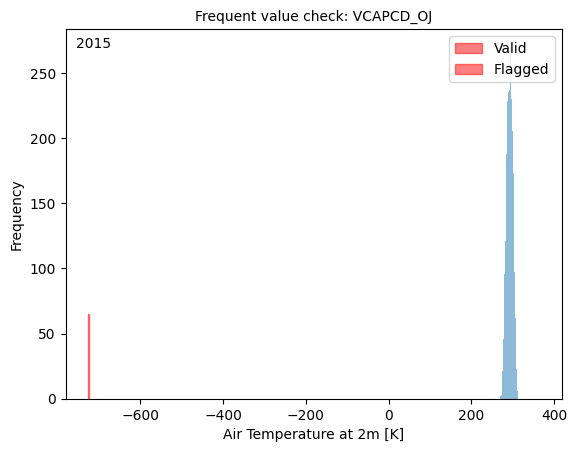

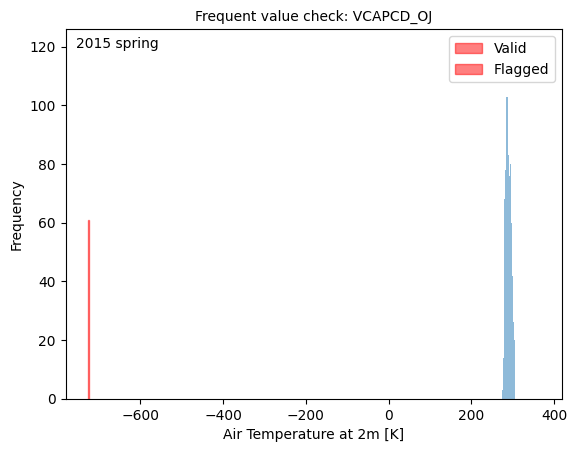

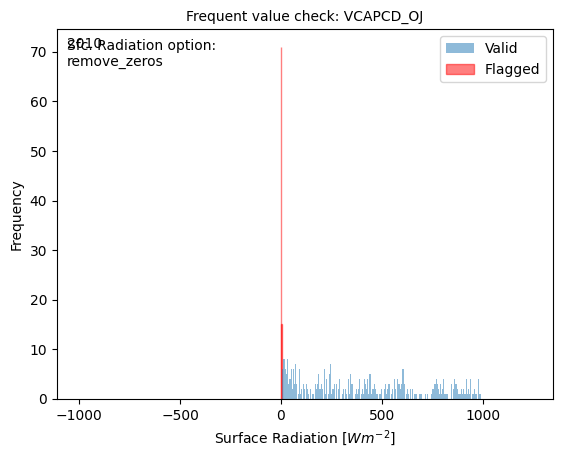

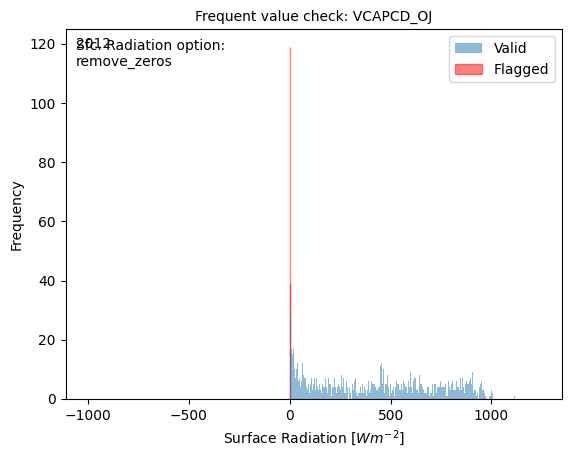

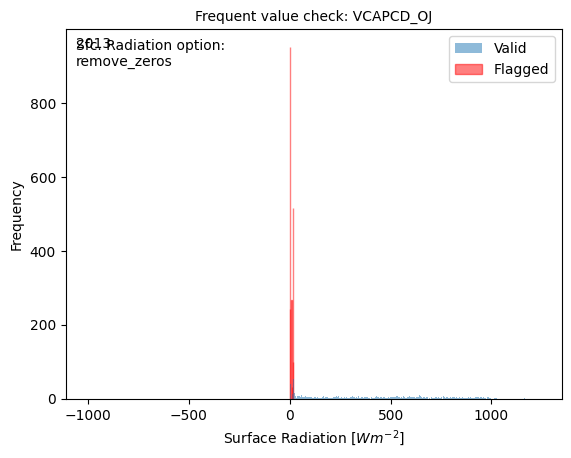

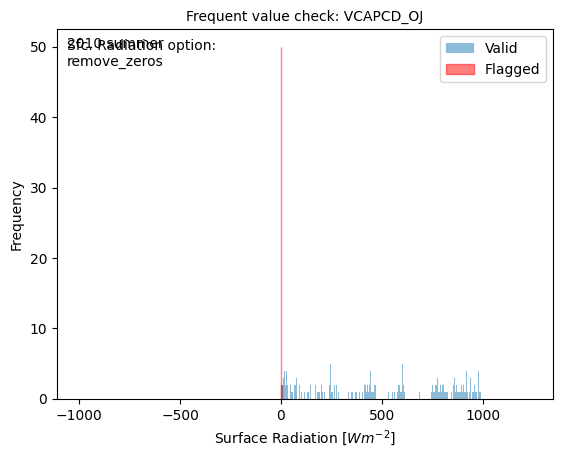

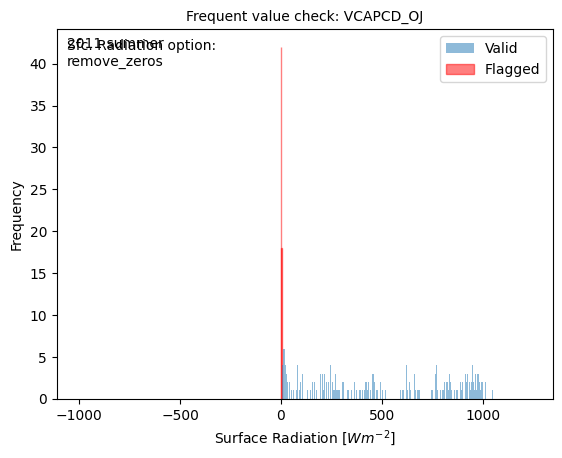

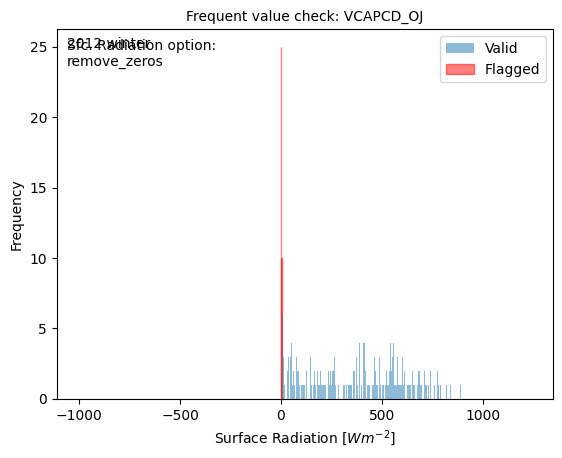

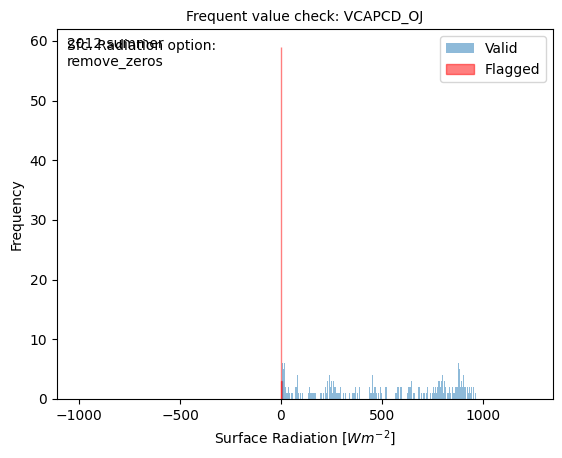

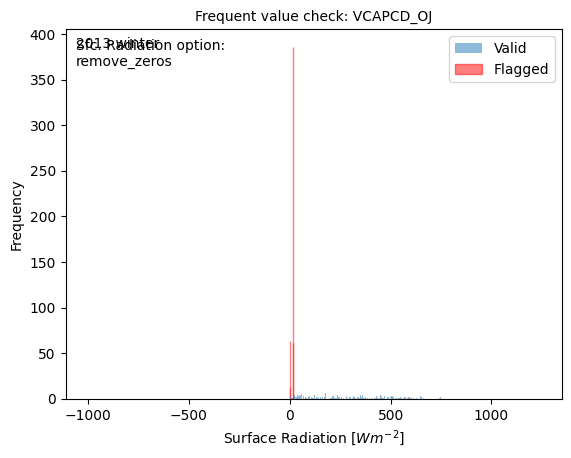

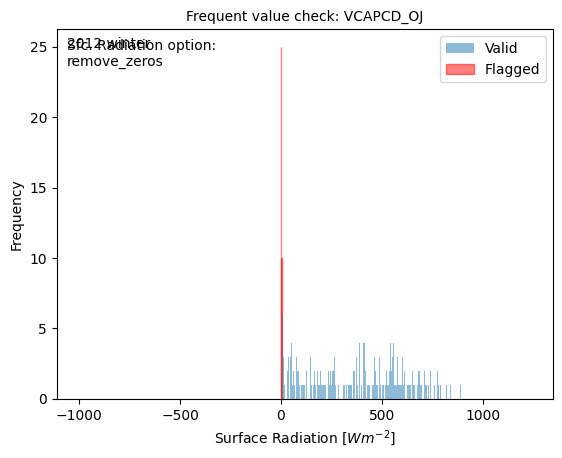

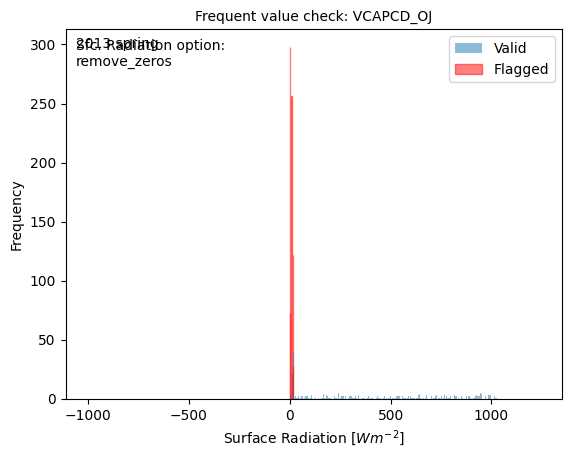

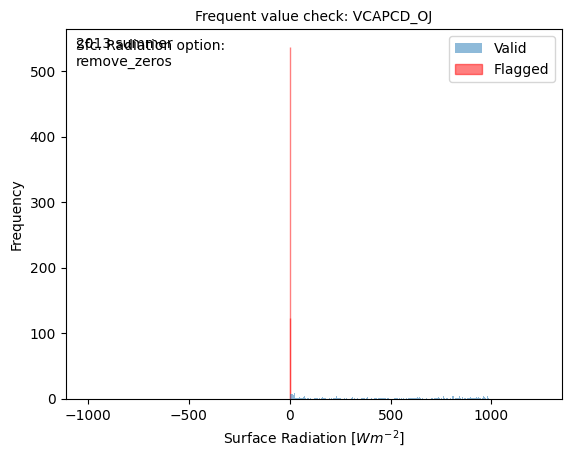

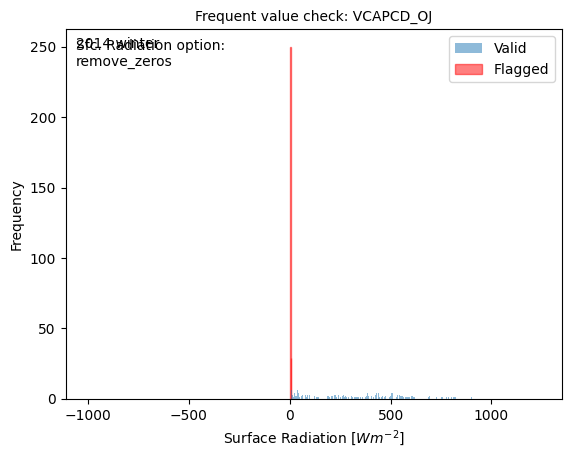

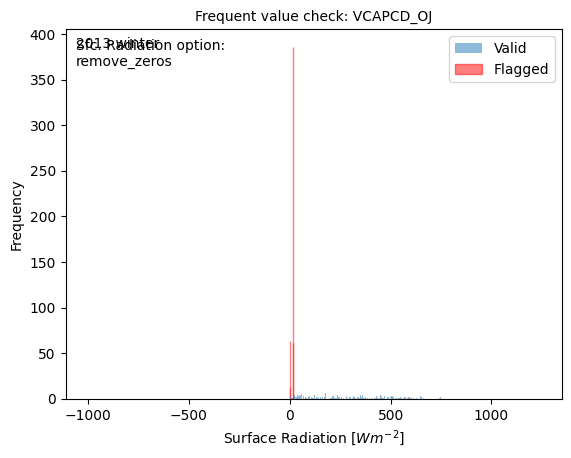

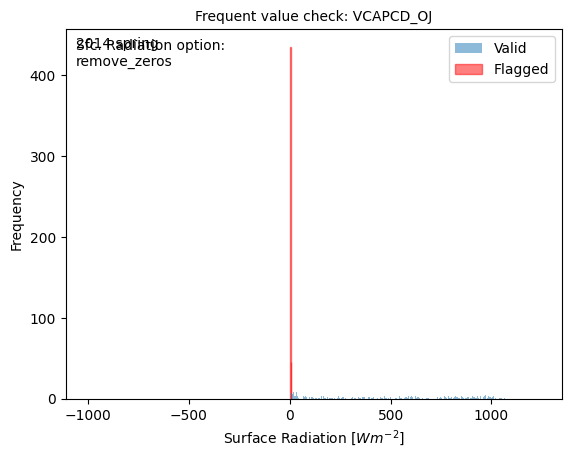

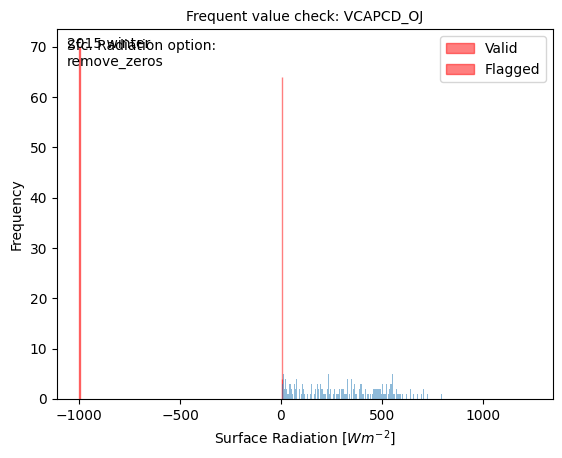

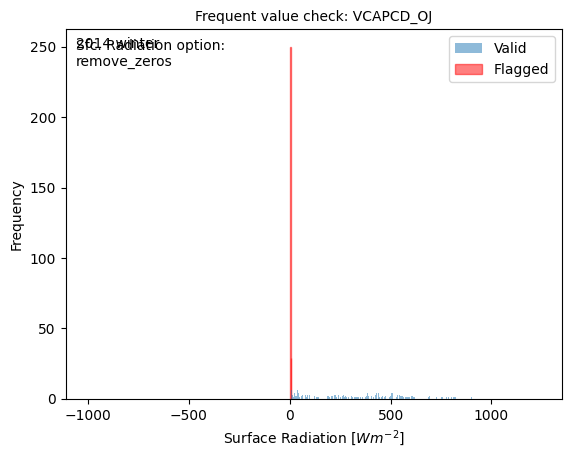

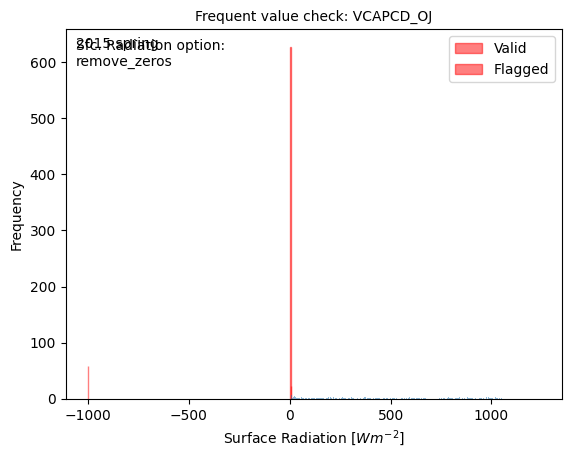

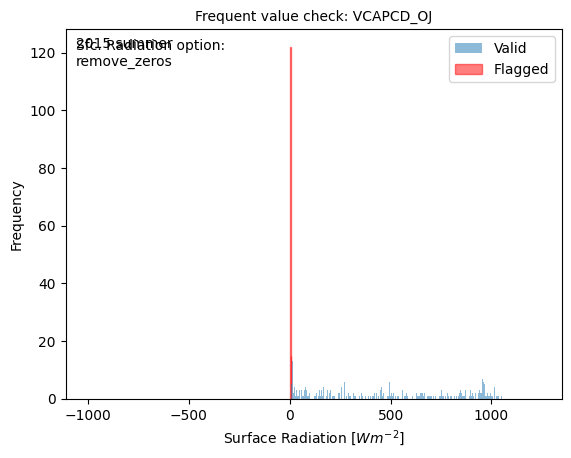

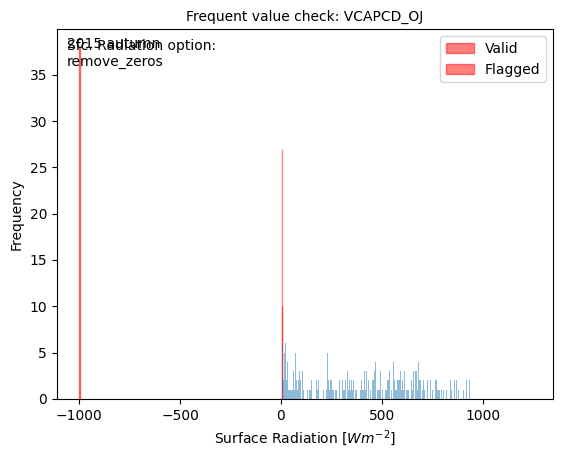

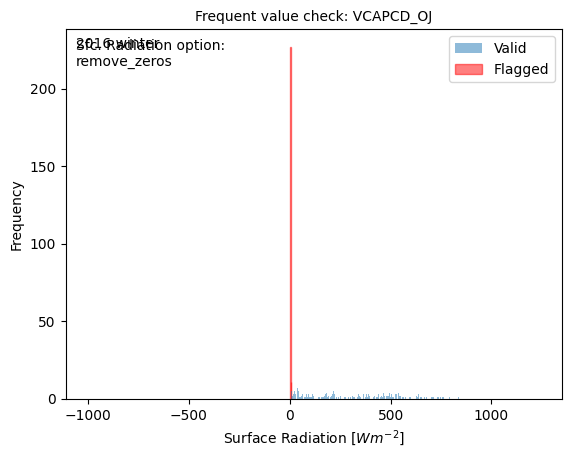

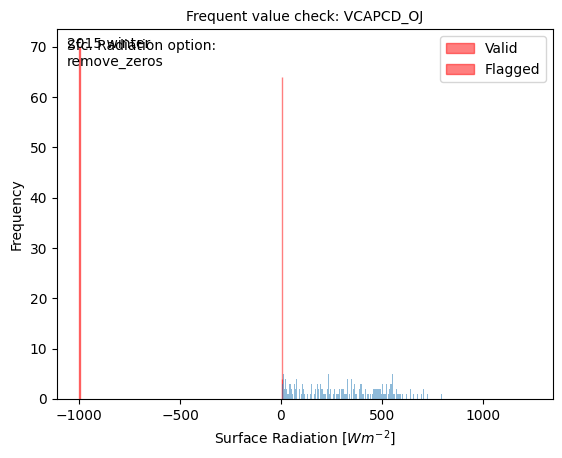

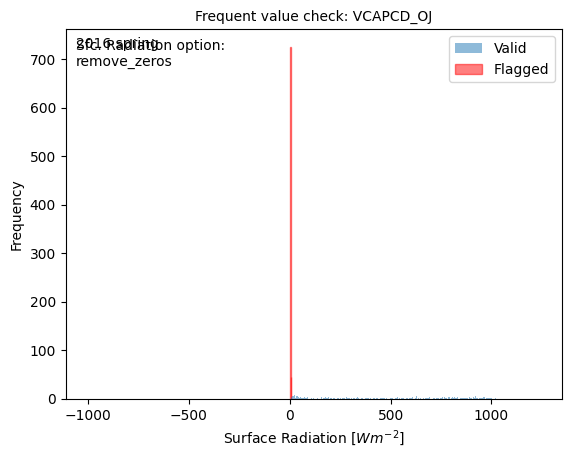

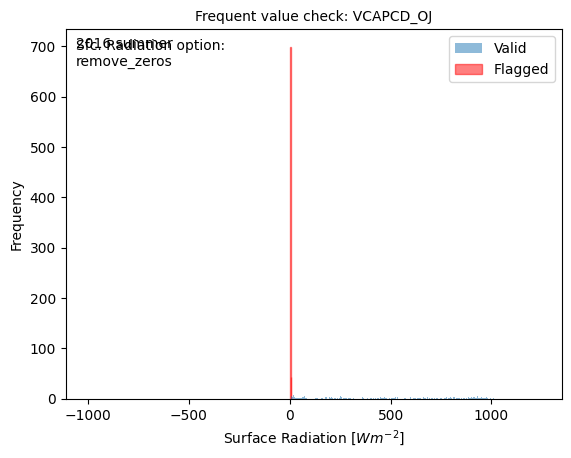

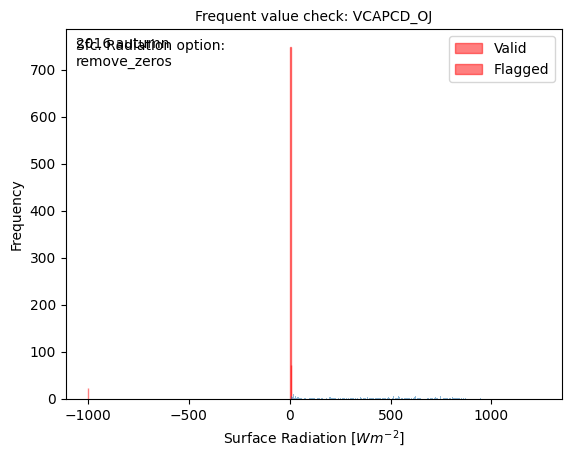

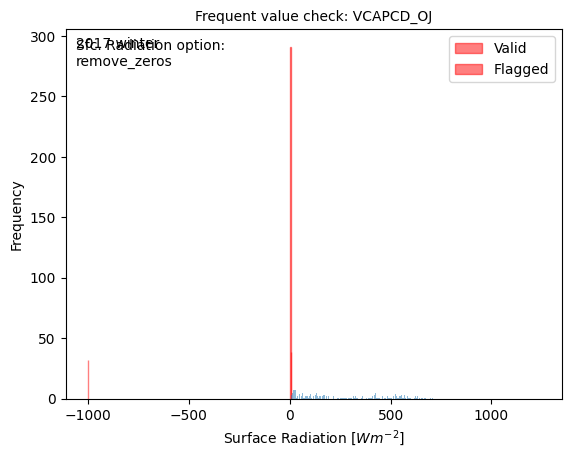

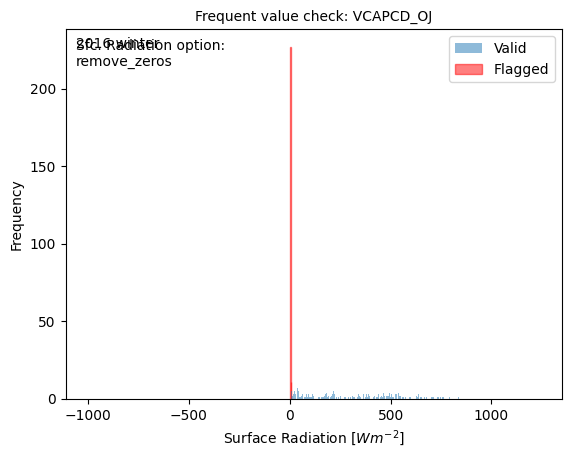

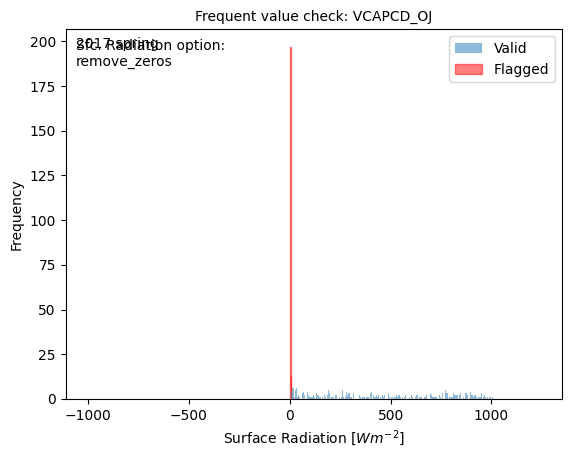

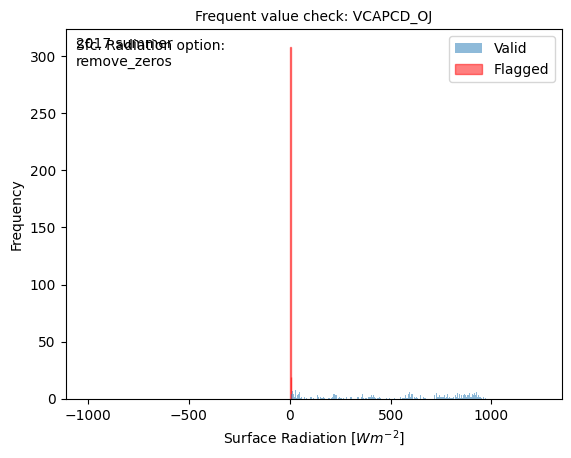

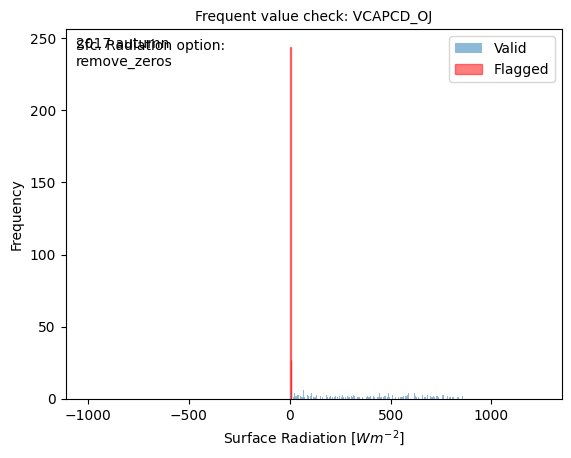

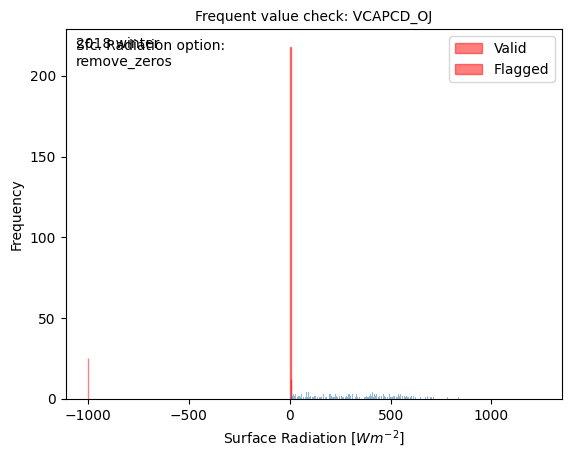

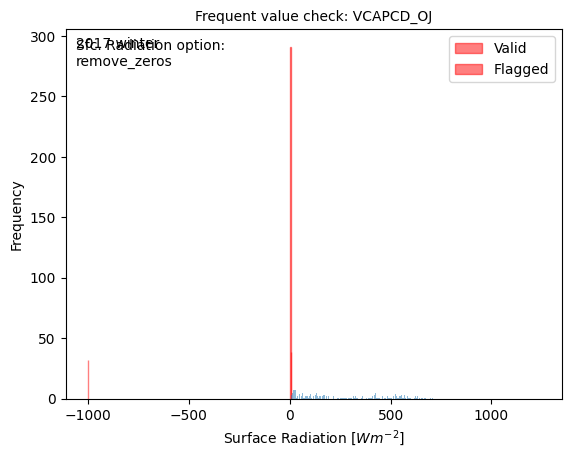

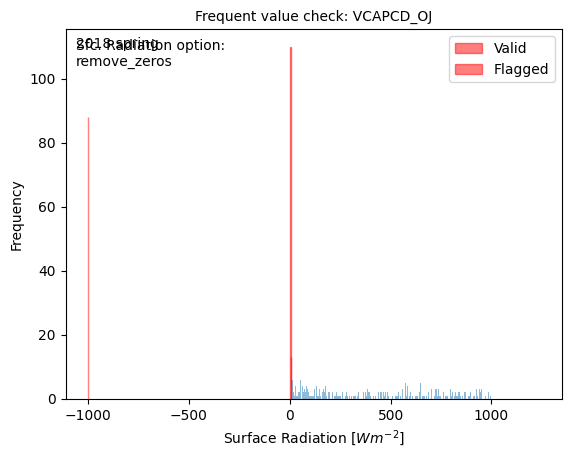

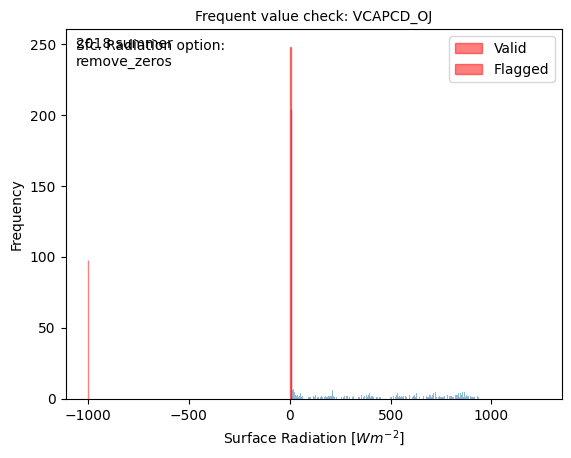

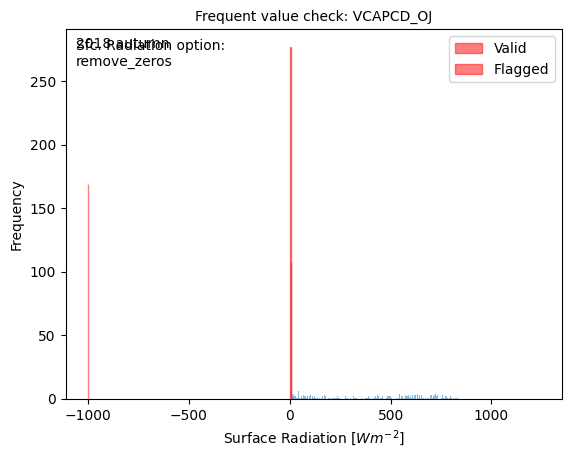

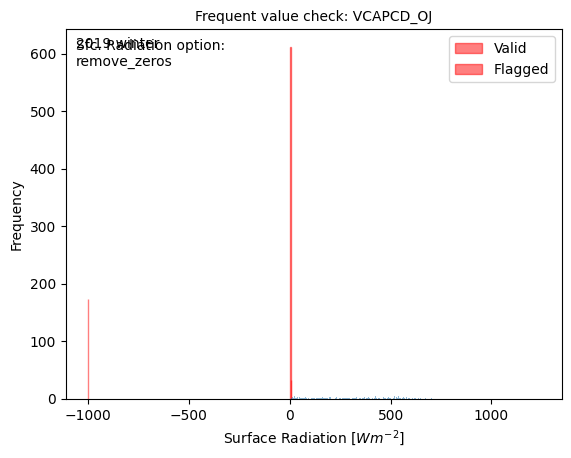

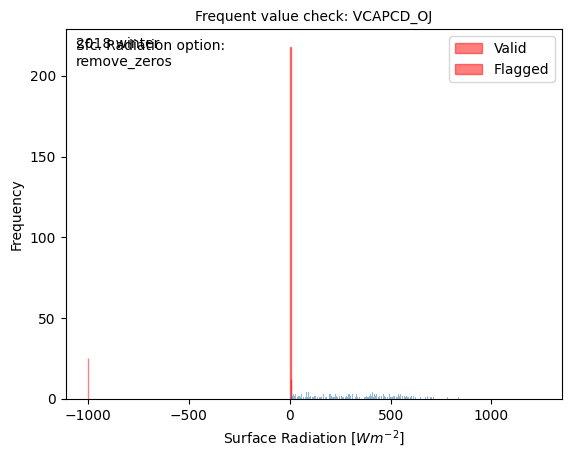

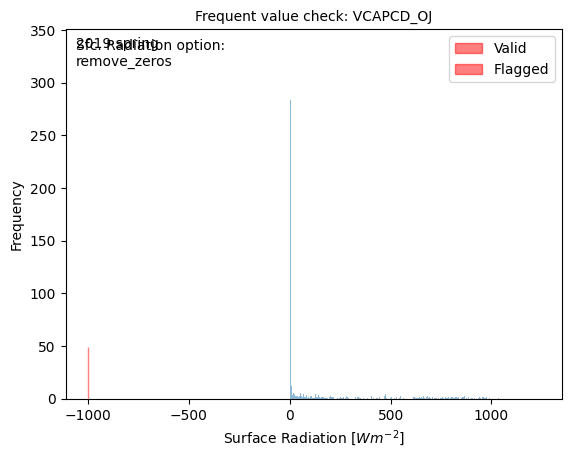

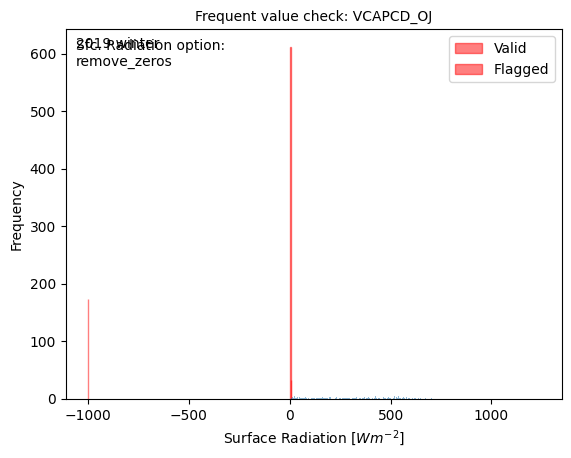

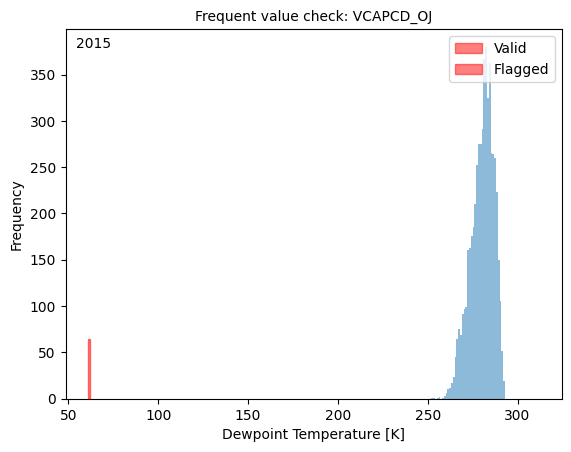

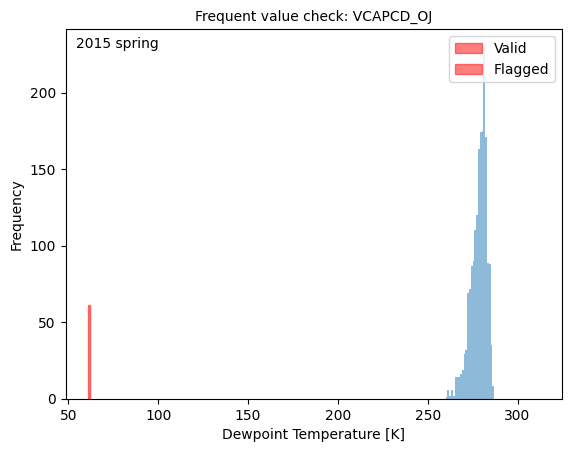

In [42]:
final_test_df = qaqc_frequent_vals(df, rad_scheme='remove_zeros', plots=True)